# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [466]:
from sklearn.datasets import make_blobs
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
import seaborn as sns

import matplotlib
%matplotlib inline


from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 11, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']

cmap = ['#F94144', '#F9C74F']

cmap_name = 'my colormap'

c_map = LinearSegmentedColormap.from_list(cmap_name, cmap)

figure_path = module_path + '/figures/cluster_filter/'

def scatterplot_with_colors(X, y):
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
    colorsDict = {idx : color for (idx, color) in enumerate(colors)}
    colorsDict[-1] = '#484848'
    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)
    grouped = df.groupby('label')
    for key, group in grouped:
        label_key = key
        if key == -1:
            label_key = 'deleted samples'
        ax = group.plot(ax=ax, kind='scatter', x='x', y='y',
                        label=label_key, color=colorsDict[key] ,
                        s = 7, alpha=0.8)


    for label in ax.get_ylabel() :
        ax.set_ylabel(label, fontproperties = font)
    for label in ax.get_xlabel() :
        ax.set_xlabel(label, fontproperties = font)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font)
    ax.legend(prop=font)
    
    return f

In [717]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter('error', UndefinedMetricWarning)

import numpy as np
import random

random.seed(10)
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


def K_means_cluster_filter(X_train, y_train, X_test, y_test,
                                     clf_dict, grid_dict = None,
                                     param_dict = None,
                                     clusters_fixed = 10,
                                     thresh_fixed = 2, folds = 7):
    result_dict = {}
    indices_dict = {}
    model = KMeans(n_clusters=clusters_fixed, random_state = 1)
    model.fit(X_train)
    
    def get_f1_acc_metric(true, pred):
        try:
            f1 = f1_score(true, pred)
        except UndefinedMetricWarning: 
            return 0
        acc = accuracy_score(true, pred)
        #return np.sqrt(f1**2 + acc**2)
        return f1
    
    
    def get_best_clusters_mask(X_test_temp, y_test_temp, clf_fold):
        cluster_marked = model.predict(X_test_temp) 
        # Get the resulting metrics (sqt(acc ^2 + f1 ^2)) for each of the current clusters

        m, s= get_metric_vector(X_test_temp, y_test_temp, clf_fold, cluster_marked)
    
        #mean_metrics = np.mean(m) - np.std(m)
        mean_metrics = np.median(m)
        keep_clusters = m > mean_metrics # Mask of which clusters to keep. If True, then keep the cluster
        
        return keep_clusters
    
    
    def get_metric_vector(X_test_temp, y_test_temp, clf_fold, cluster_marked):
        me = []
        sizes = []
        for idx in range(clusters_fixed): 
            indices = np.where(cluster_marked == idx)
            X_test_cluster = X_test_temp.iloc[indices]
            y_test_cluster = y_test_temp.iloc[indices]

            y_pred = clf_fold.predict(X_test_cluster)
            me.append(get_f1_acc_metric(y_test_cluster, y_pred))
            sizes.append(len(y_test_cluster))
        return np.array(me) , np.array(sizes)
    
    # Loop through all the classifiers in the dataset
    
    for name, clf in clf_dict.items():
        if param_dict and (name in param_dict.keys()): 
            clusters = param_dict[name]['custers']
            thresh = param_dict[name]['threshold']
        else:
            clusters = clusters_fixed
            thresh = thresh_fixed
        #print(f'Setting the initial classifier, for {name}')
        if grid_dict and (name in grid_dict.keys()):
            def get_initial_classifier(clf_initial, grid):
                grid_cv=GridSearchCV(clf_initial,grid,cv=5)
                grid_cv.fit(X_train,y_train)
                return grid_cv.best_estimator_

            #print('Grid search option is activated ')
            clf_init = get_initial_classifier(clf, grid_dict[name]).fit(X_train, y_train)
            clf_dict[name] = clf_init
        else: 
            clf_init = clf.fit(X_train, y_train)
            
        ## Finding the initical classifier, and storing its performance
        
        temp_dict = {}
        y_pred_init = clf_init.predict(X_test)

        metric_original = get_f1_acc_metric(y_test, y_pred_init)
        
        
        temp_dict['original'] = metric_original
        
        def clustering_based_filter():
            '''
            Uses the defined dimentionality reduced version of the dataset, with k means clustering, 
            to form clusters in the test set, which are tested seperatly. By either leaving one cluster out, 
            or only including one cluster

            '''
            ensemble_mask = []
            skf = StratifiedKFold(n_splits=folds)
            
            for train_index, test_index in skf.split(X_train, y_train):
                X_train_temp, X_test_temp = X_train.iloc[train_index], X_train.iloc[test_index]
                y_train_temp, y_test_temp = y_train.iloc[train_index], y_train.iloc[test_index]
                clf_fold = clf.fit(X_train_temp, y_train_temp)
                
                temp_mask = get_best_clusters_mask(X_test_temp, y_test_temp, clf_fold)

                ensemble_mask.append(temp_mask)

            best_cluster_mask = np.array(ensemble_mask).sum(axis = 0) > thresh

            ## Using the best cluster mask on the test set
            X_test_marked_clusters = model.predict(X_test)
            metrics, s = get_metric_vector(X_test, y_test, clf_init, X_test_marked_clusters)


            keep_clusters = np.where(best_cluster_mask == True)[0] 

            if len(keep_clusters) > 1:
                keep_indices = np.concatenate([np.where(X_test_marked_clusters == l)[0] for l in keep_clusters])
            else: 
                keep_indices = np.where(X_test_marked_clusters == keep_clusters[0])[0]

            return metrics, keep_indices
        
        metric, indices = clustering_based_filter()
        
        indices_dict[name] =  indices
        
        #y_pred_new = clf_init.predict(X_test.iloc[indices])
        #temp_dict['filtered'] = get_f1_acc_metric(y_test.iloc[indices], y_pred_new)
        #result_dict[name] = temp_dict
        result_dict[name] = metric
        
    return result_dict, indices_dict


def hyperparam_search(X_train, y_train, X_test, y_test,
                                     clf_dict, grid_dict = None,
                                     clusters_list = [10], thresh_list = [2]):
    max_diff = {key: 0 for key, val in clf_dict.items()}
    return_dict = {}
    for t in thresh_list:
        for k in clusters_list:
            #print(f'Testing number of clusters = {k}, and threshold = {t}')
            temp_dict, _ = K_means_cluster_filter(X_train, y_train, X_test, y_test,
                                         clf_dict, grid_dict,
                                         clusters_fixed = k, thresh_fixed = t)

            for key, val in temp_dict.items():
                diff = np.std(val)
                #diff = np.mean(metrics) - min(metrics) # Need to fix return value to make this the filtering criteria

                #diff = val['filtered'] - val['original']
                if diff > max_diff[key]:
                    max_diff[key] = diff
                    return_dict[key] = {'custers': k, 'threshold': t}
                
    return return_dict

def hyperparam_search_alt(X_train, y_train, X_test, y_test,
                                     clf_dict, grid_dict = None,
                                     clusters_list = [10], thresh_list = [2]):         
    max_diff = {key: 0 for key, val in clf_dict.items()}
    return_dict = {}
    for t in thresh_list:
        for k in clusters_list:
            #print(f'Testing number of clusters = {k}, and threshold = {t}')
            noise_X, n_idx= add_noise_dataset(X_test, random.randint(1,20), random.randint(3,8))
            results, indices = K_means_cluster_filter(X_train, y_train, noise_X, y_test,
                                         clf_dict, grid_dict,
                                         clusters_fixed = k, thresh_fixed = t)
            
            def alt_optimal_check():
                amount_of_noise_removed = {}
                for name, vals in indices.items():
                    keep = indices[name] 
                    count = 0
                    for idx in n_idx:
                        if idx not in keep: 
                            count = count + 1
                    amount_of_noise_removed[name] = (count/len(n_idx))
                return amount_of_noise_removed
            
            amount_of_noise_removed = alt_optimal_check()

            for key, val in results.items():
                if amount_of_noise_removed[key] > max_diff[key]:
                    max_diff[key] = amount_of_noise_removed[key]
                    return_dict[key] = {'custers': k, 'threshold': t}
    '''                
    for name, prop in return_dict.items():
        k = prop['custers']
        model = KMeans(n_clusters=k, random_state = 1)
        model.fit(X_train)
        new_y = model.predict(X_train)
        print(f'Optimal clustering for {name}: {k} - clusters \n')
        f = scatterplot_with_colors(X_train.values, new_y)
        plt.show()'''
    return return_dict


def add_noise_dataset(X, ampl = 10, noise_amount = 4):
    '''
    noise amount is inverse, meaning higher noise amout, means less noise... 
    '''
    noise_indices = np.random.RandomState(seed=1).permutation(X.index.tolist())[0:len(X)//noise_amount]
    new_X = X.copy()
    for [idx, row] in new_X.iterrows():
        if idx in noise_indices:
            sig = row
            noise = np.random.RandomState(seed=idx%10).normal(0, ampl, len(sig))
            new_X.iloc[idx] = pd.Series((sig + noise).tolist())
    return new_X , noise_indices

def get_best_classifier_in_dict(result_dict):
        maxi = 0
        best_name = ''
        for name, val in result_dict.items():
            diff = val['filtered'] - val['original']
            if diff > maxi:
                maxi = diff
                best_name = name
        return name
    
    
def get_best_classifier_in_dict_alt(result_dict):
        maxi = 0
        best_name = ''
        for name, val in result_dict.items():
            diff = max(val)
            if diff > maxi:
                maxi = diff
                best_name = name
        return name

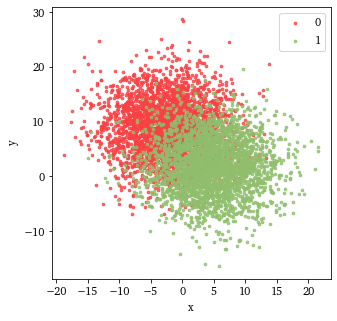

In [643]:
from sklearn.model_selection import train_test_split

import pandas as pd

# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 42)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

y = y.astype(int)
X.columns = np.arange(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

f = scatterplot_with_colors(X.values, y.values)

In [718]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


k_range = list(range(1,8))
cluster_range = list(range(10,15))
thresh_range = list(range(2,4))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knn': KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1),
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

param_dict = hyperparam_search(X_train, y_train, X_val, y_val,
                                   clf_dict, grid_dict = grid_dict,
                                   clusters_list = cluster_range,
                                  thresh_list = thresh_range)

### Plotting performance on validation set

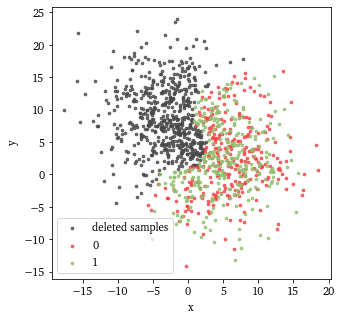

In [719]:
results, indices = K_means_cluster_filter(X_train, y_train, X_val, y_val, clf_dict,
                                     param_dict = param_dict)

name = get_best_classifier_in_dict_alt(results)

mask=np.full(len(y_test),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(X_val.values, new_y_test.values)

### Test set filtering

In [ ]:
results, indices = K_means_cluster_filter(X_train, y_train, X_test, y_test, clf_dict,
                                     param_dict = param_dict)

name = get_best_classifier_in_dict_alt(results)

mask=np.full(len(y_test),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(X_test.values, new_y_test.values)
f.savefig(figure_path + 'simulated_data_cluster_filtered.pdf', bbox_inches='tight')

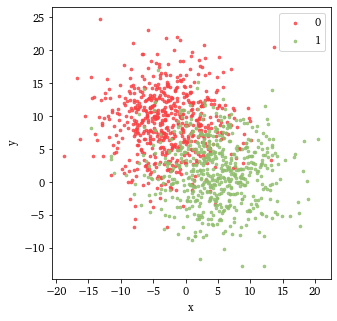

In [709]:
f = scatterplot_with_colors(X_test.values, y_test.values)

f.savefig(figure_path + 'simulated_data_cluster_not_filtered.pdf', bbox_inches='tight')

# Adding noise

In [710]:
new_X, n_idx= add_noise_dataset(X_test, 20, 3)

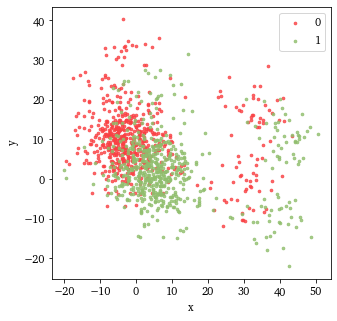

In [711]:
scatterplot_with_colors(new_X.values, y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_cluster_not_filtered.pdf', bbox_inches='tight')

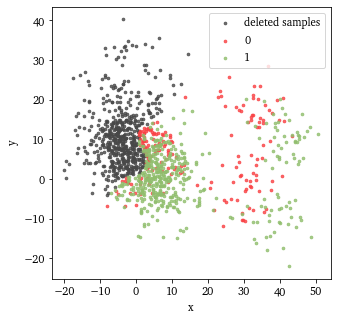

In [712]:
results, indices = K_means_cluster_filter(X_train, y_train, new_X, y_test, clf_dict, param_dict = param_dict)

name = get_best_classifier_in_dict_alt(results)

mask=np.full(len(new_X),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(new_X.values, new_y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_cluster_filtered.pdf', bbox_inches='tight')